In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor
import shap

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [6]:
ordinal_data = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/data_ordinal.csv') 
frame = ordinal_data.copy()
frame0 = frame.copy()
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

frame = frame[frame['SaleCondition'] == 4]


In [7]:
dataset = 'ordinal'
model_name = 'xgboost_tuned'
trial = "onlyNormalCondition"


#the features will be X (independent variables)
X = frame.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = frame['SalePrice']
y_array = y.values

params =  {'max_depth': 3,
             'learning_rate': 0.0836719064919561,
             'n_estimators': 629,
             'min_child_weight': 2,
             'colsample_bytree': 0.2015968025244805,
             'subsample': 0.7345072578143232,
             'reg_alpha': 0.9256222240627585,
             'reg_lambda': 0.16575971012532154}

#Input parameters into the model
best_model = xgb.XGBRegressor(**params)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')


# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)

# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)


In [8]:
# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores, '\n')
# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n') 

Cross-Validation Scores: [0.95155012 0.95090586 0.93213528 0.94454715 0.94850518] 

Mean R^2: 0.9455287175336885 



In [13]:
#  #Split your training and testing sets of data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# # Train the model on the training set
# best_model.fit(X_train, y_train)

# # Make predictions on the test set
# predictions = best_model.predict(X_test)

NameError: name 'X_train' is not defined

In [10]:
# Perform cross-validation and obtain predictions
predicted_values = cross_val_predict(best_model, X, y, cv=kf)

# Calculate residuals
residuals = y - predicted_values


In [12]:
# Assuming you have a trained CatBoostRegressor model named 'catboost_model'
feature_importance = best_model.feature_importances_

# Get feature names from the training dataset
your_feature_names = X.columns  # Replace 'X' with your feature matrix

# Create a DataFrame for better handling
feature_importance_df = pd.DataFrame({'Feature': your_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='blue')
plt.xlabel('Importance')
plt.title('Top 10 Features - CatBoost Feature Importance')
plt.show()

NotFittedError: need to call fit or load_model beforehand

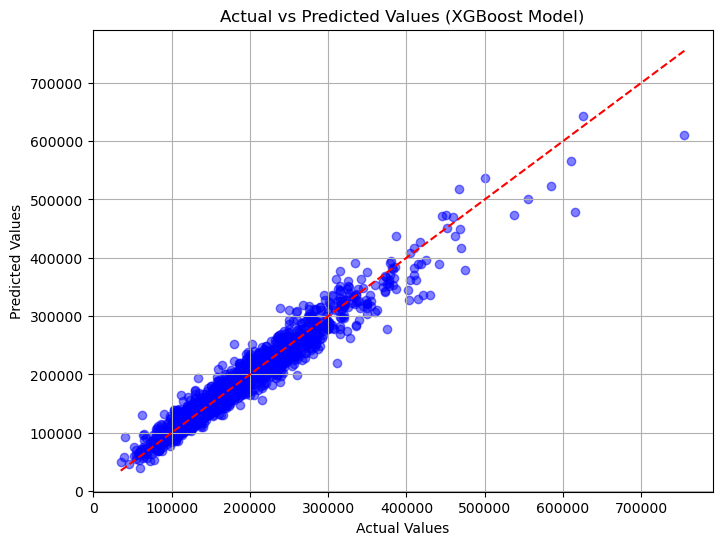

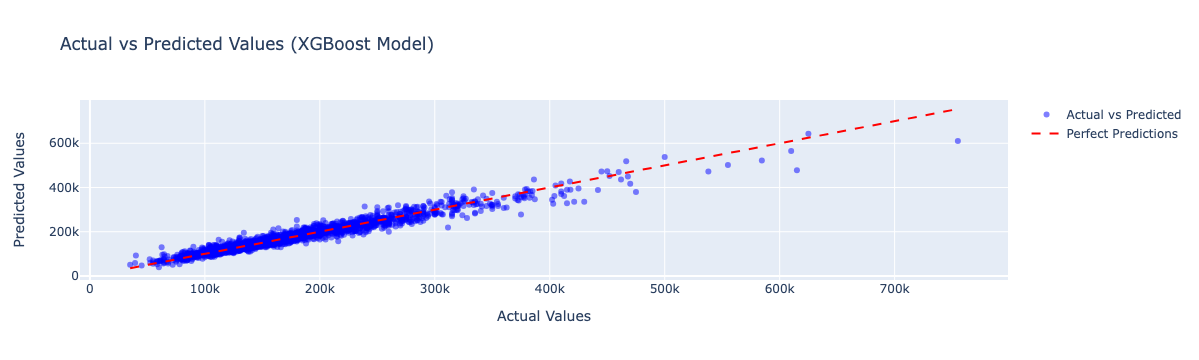

In [15]:
# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, predicted_values, color='blue', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (XGBoost Model)')
plt.grid(True)
plt.show()

# Create a scatter plot
scatter_plot = go.Scatter(x=y, y=predicted_values, mode='markers', 
                          marker=dict(color='blue', opacity=0.5),
                          name='Actual vs Predicted')

# Add a diagonal line representing perfect predictions
diagonal_line = go.Scatter(x=[min(y), max(y)], y=[min(y), max(y)],
                           mode='lines', line=dict(color='red', dash='dash'),
                           name='Perfect Predictions')

# Layout
layout = go.Layout(title='Actual vs Predicted Values (XGBoost Model)',
                   xaxis=dict(title='Actual Values'),
                   yaxis=dict(title='Predicted Values'),
                   showlegend=True)

# Create figure
scatter_fig = go.Figure(data=[scatter_plot, diagonal_line], layout=layout)

# Show plot
scatter_fig.show()


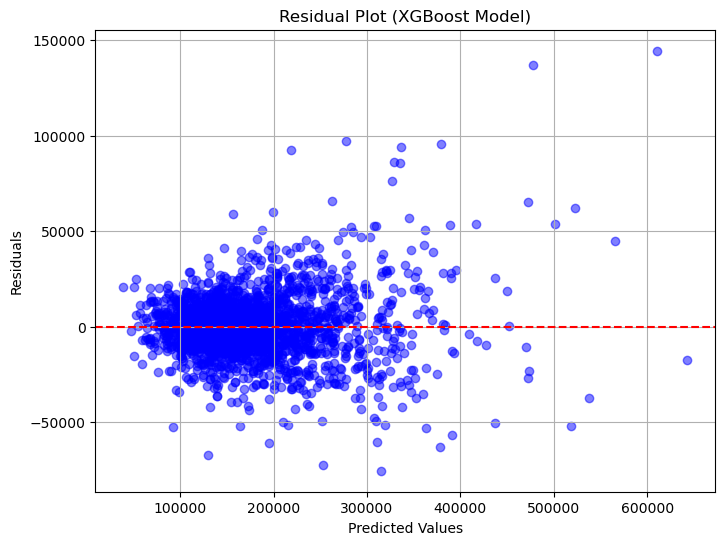

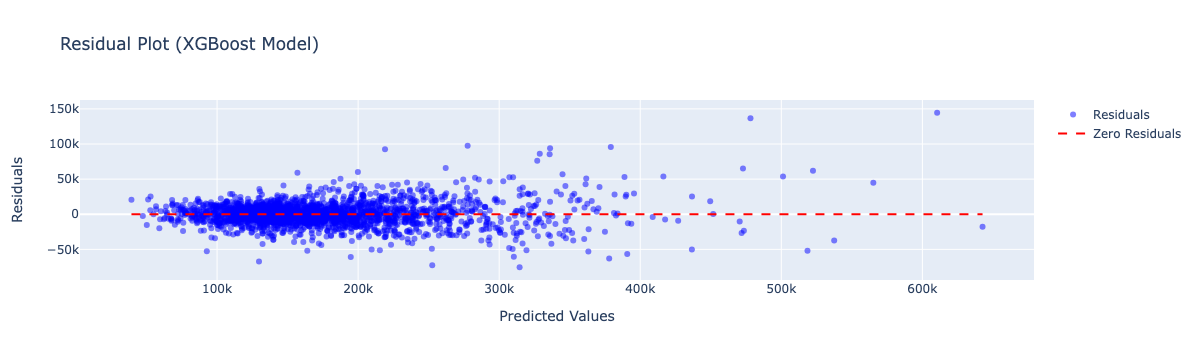

In [16]:


# Plotting residuals against predicted values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost Model)')
plt.grid(True)
plt.show()

# Create a scatter plot
residual_plot = go.Scatter(x=predicted_values, y=residuals, mode='markers', 
                           marker=dict(color='blue', opacity=0.5),
                           name='Residuals')

# Add a horizontal line at y=0
horizontal_line = go.Scatter(x=[min(predicted_values), max(predicted_values)], y=[0, 0],
                             mode='lines', line=dict(color='red', dash='dash'),
                             name='Zero Residuals')

# Layout
layout = go.Layout(title='Residual Plot (XGBoost Model)',
                   xaxis=dict(title='Predicted Values'),
                   yaxis=dict(title='Residuals'),
                   showlegend=True)

# Create figure
residual_fig = go.Figure(data=[residual_plot, horizontal_line], layout=layout)

# Show plot
residual_fig.show()


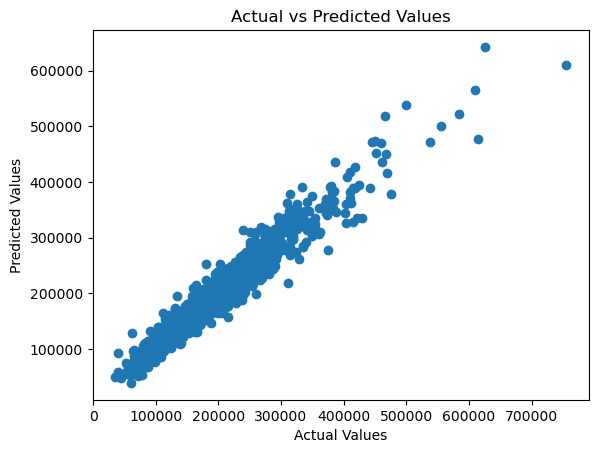

In [17]:
# Plotting actual vs predicted values
plt.scatter(y, predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [19]:
best_model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.2015968025244805, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0836719064919561, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=629, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

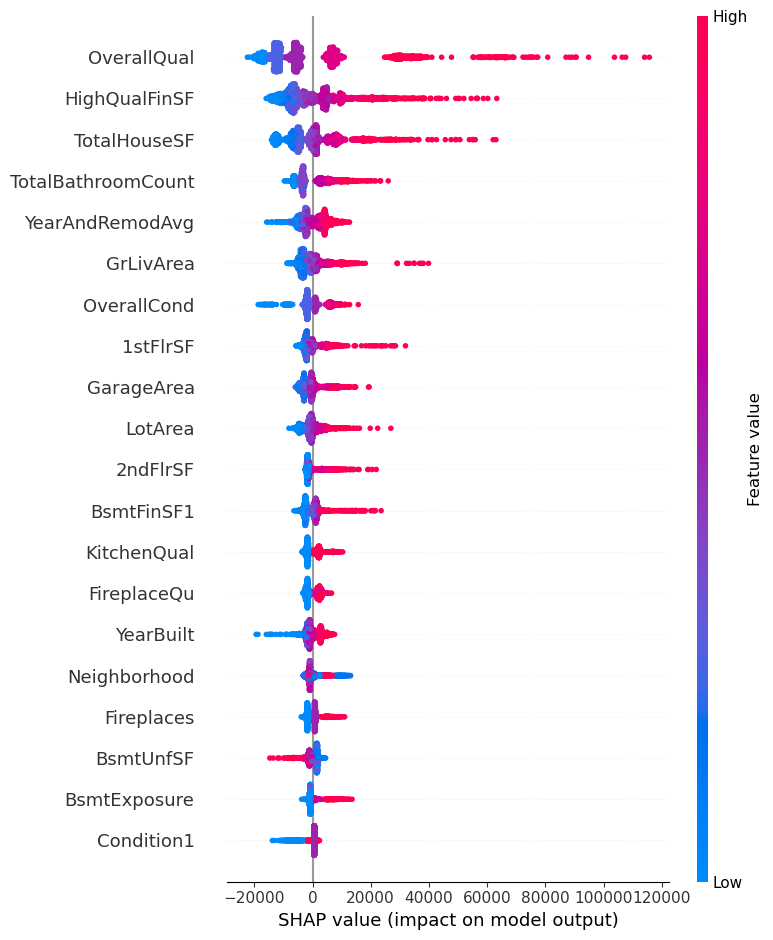

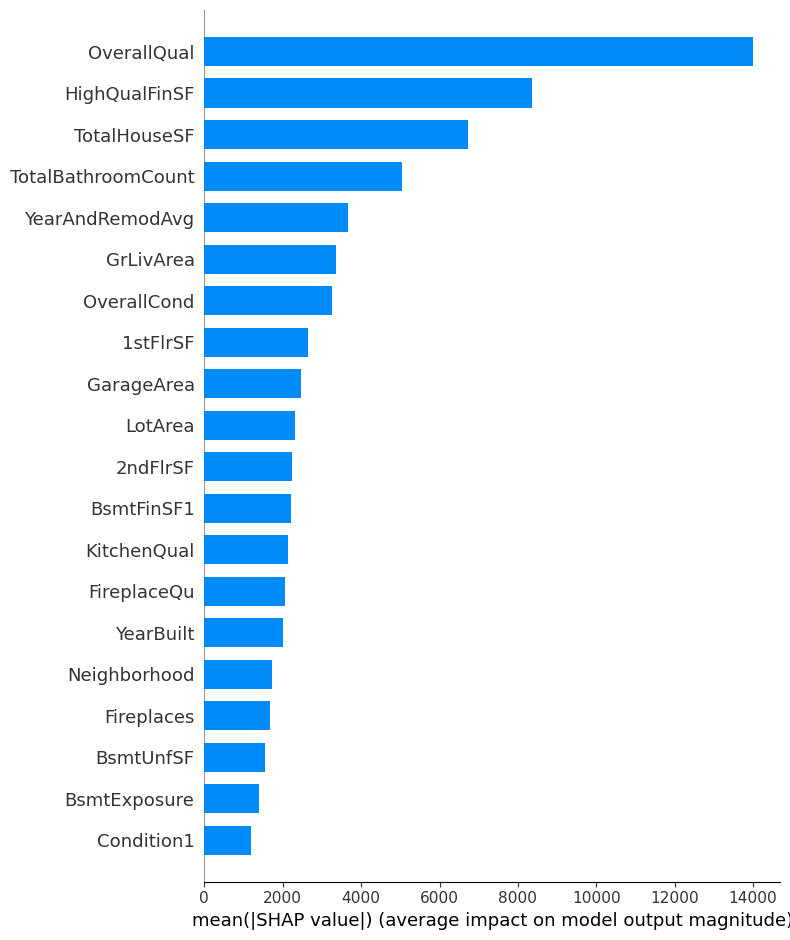

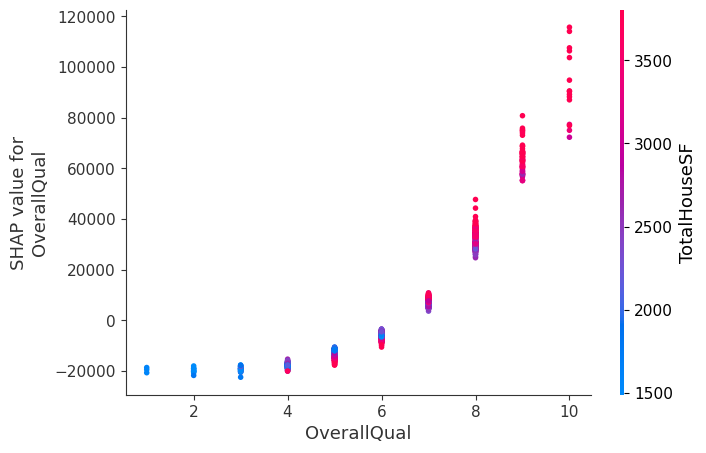

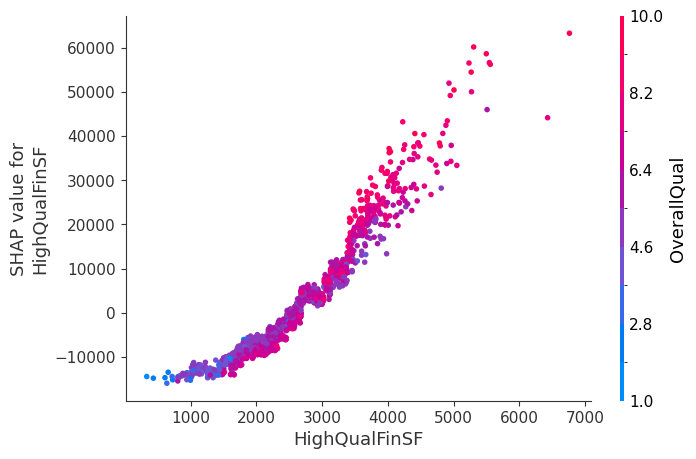

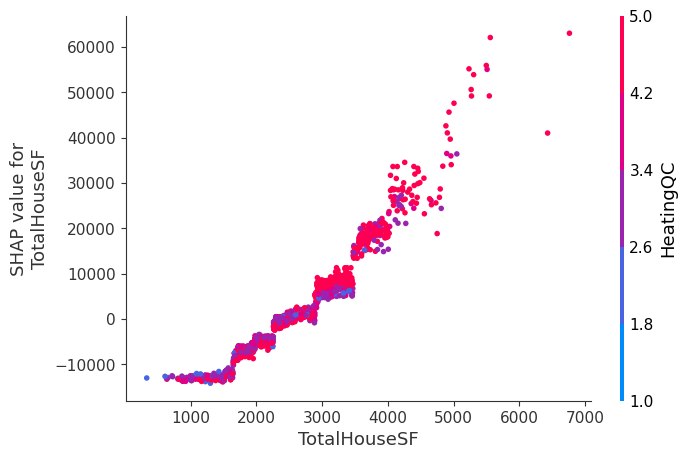

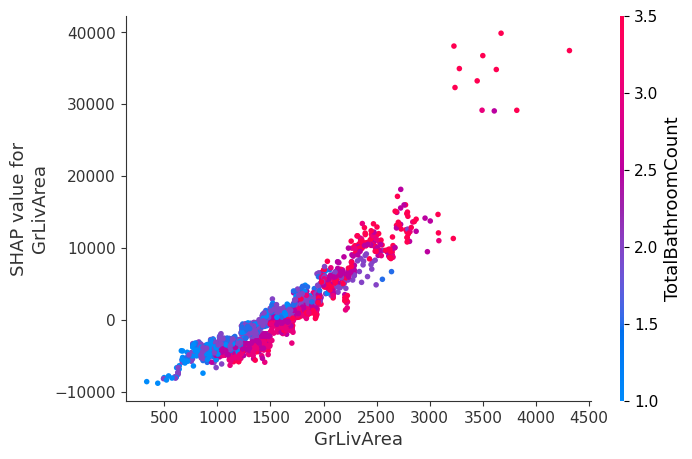

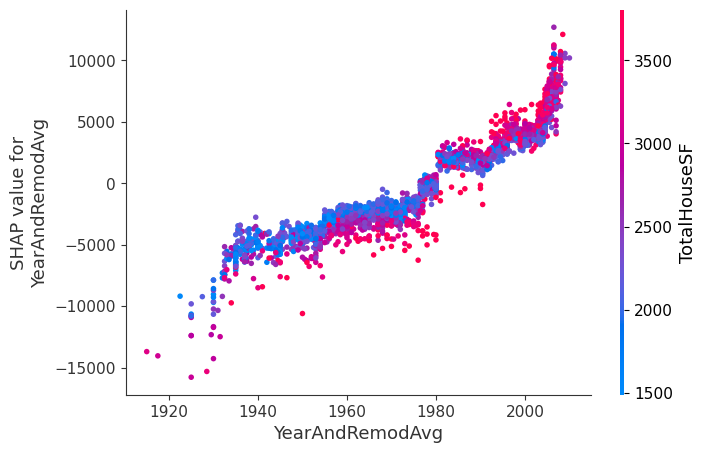

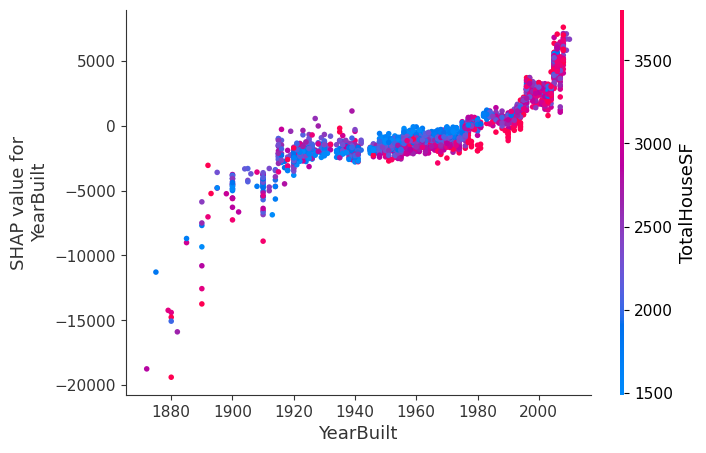

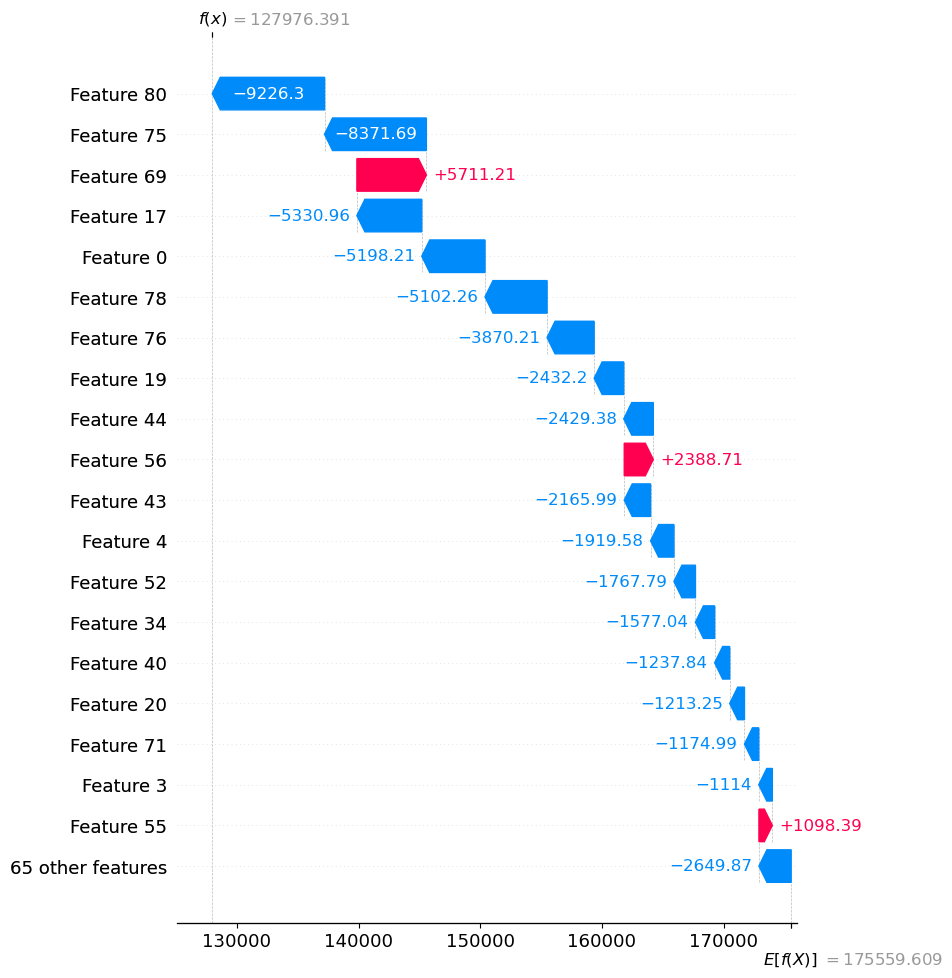

In [168]:
# Use the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X)

# 1. Summary Plot
shap.summary_plot(shap_values, X)

# 2. Summary Bar Plot
shap.summary_plot(shap_values, X, plot_type="bar", show=False)

# 3. Dependence Plot
shap.dependence_plot("OverallQual", shap_values, X)
shap.dependence_plot("HighQualFinSF", shap_values, X)
shap.dependence_plot("TotalHouseSF", shap_values, X)
shap.dependence_plot("GrLivArea", shap_values, X)

#shap.dependence_plot("KitchenQual", shap_values, X_test)
shap.dependence_plot("YearAndRemodAvg", shap_values, X)
shap.dependence_plot("YearBuilt", shap_values, X)



# 4. Force Plot (for a specific prediction)
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

# 5. Waterfall Plot (for a specific prediction)
shap.waterfall_plot(shap.Explanation(values=shap_values[0, :], base_values=explainer.expected_value), max_display=20)


In [21]:
feature_names = X.columns.tolist()

# Create a DataFrame with SHAP values
shap_df = pd.DataFrame(shap_values, columns=feature_names)
shap_df.describe()

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.0,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.0,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000
mean,-239.926300,35.511879,4.558093,105.104813,-140.500443,3.150360,-5.089588,19.465309,-18.230669,0.0,-9.184189,1.895338,87.700478,14.468629,-1.576775,23.600920,-8.820882,231.089859,89.290291,19.292927,-90.740181,-8.574772,-0.107227,-8.537624,7.465737,9.939936,-159.345490,-107.804619,0.960973,-154.775269,-30.708565,2.402845,57.845551,-13.164850,-45.181850,-4.782662,12.474881,-0.201277,-49.035645,5.167366,-134.708313,59.105873,3.243175,4.150111,-85.166451,-1.101826,24.547504,-3.717377,111.867424,-8.809891,-34.698223,22.893124,-12.346127,-196.989899,24.592237,-23.043074,121.106369,-40.918175,-27.129383,-94.628181,82.203773,-300.219452,-0.388818,31.643919,5.897805,10.398613,-8.283050,-28.021927,-0.589716,34.748371,-5.266510,-1.118975,-8.204784,-2.040399,0.0,501.330383,56.987293,-124.429176,-30.223061,-3.877966,143.177689,44.148430,11.544096,176.378571
std,4772.973145,786.876404,1106.117798,1384.439331,3219.829590,231.041641,463.406433,495.698517,489.417236,0.0,633.334351,433.027069,2585.513916,2085.612305,290.361755,904.246582,532.485596,19234.044922,4419.122070,2606.695557,1225.345093,451.254089,495.090851,1191.872192,239.722763,122.374557,1992.943970,810.852539,256.520966,1022.146606,1150.409546,365.789032,2288.686035,661.166443,3226.057861,109.022812,658.023438,2017.592773,983.354431,99.014603,1189.900879,1340.985229,93.079742,3795.354248,3042.369141,185.635361,511.022400,68.837967,131.620514,82.730850,466.293060,602.327026,2495.281982,824.922546,2082.354980,2176.824463,2156.378174,616.671570,1484.225464,408.176331,748.996460,3564.093262,104.076805,581.914429,426.784210,711.899963,720.127869,799.570801,201.482880,1827.109253,88.878456,1038.387573,232.612076,176.518417,0.0,9639.212891,5746.074707,1257.451782,4248.306152,1452.088379,11108.236328,876.564941,946.363708,455.689148
min,-8839.781250,-2848.458252,-7035.485352,-6639.058105,-8117.947266,-4891.417480,-583.063049,-961.061707,-1929.983398,0.0,-5052.898438,-371.321106,-3234.186035,-13812.859375,-5038.883301,-3064.266113,-1194.626953,-22402.490234,-18689.19

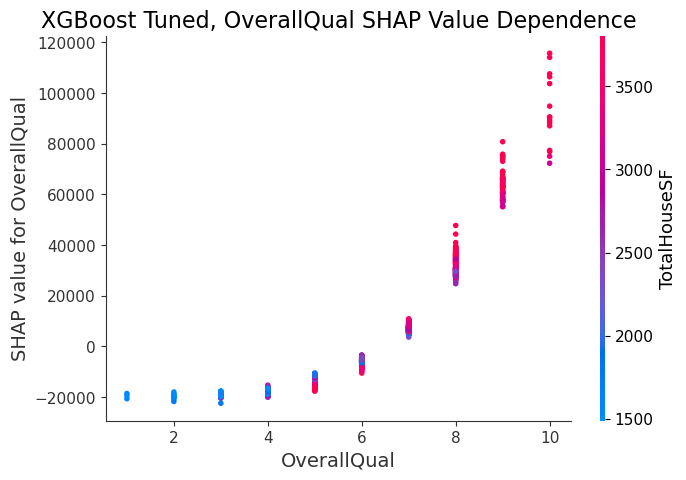

In [103]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("OverallQual", shap_values, X, interaction_index="TotalHouseSF", show=False)

plt.title('XGBoost Tuned, OverallQual SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for OverallQual', fontsize=14)
plt.xlabel('OverallQual', fontsize=14);
plt.show()

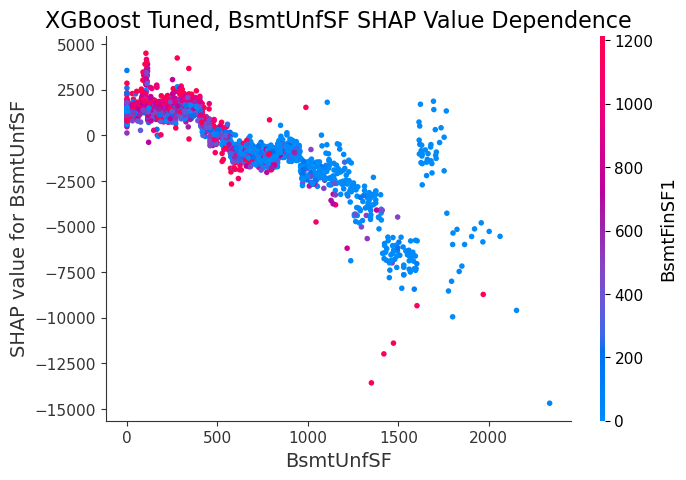

In [86]:
shap.dependence_plot("BsmtUnfSF", shap_values, X, interaction_index="BsmtFinSF1", show=False)


plt.title('XGBoost Tuned, BsmtUnfSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for BsmtUnfSF', fontsize=14)
plt.xlabel('BsmtUnfSF', fontsize=14);
plt.show()


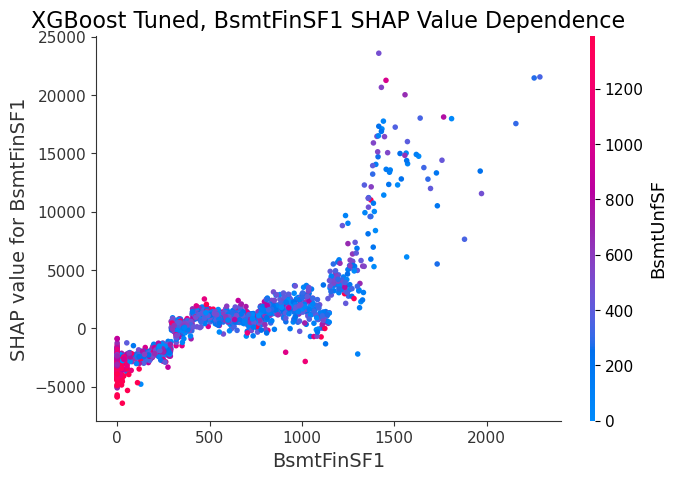

In [125]:
shap.dependence_plot("BsmtFinSF1", shap_values, X, interaction_index='BsmtUnfSF', show=False)


plt.title('XGBoost Tuned, BsmtFinSF1 SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for BsmtFinSF1', fontsize=14)
plt.xlabel('BsmtFinSF1', fontsize=14);
plt.show()


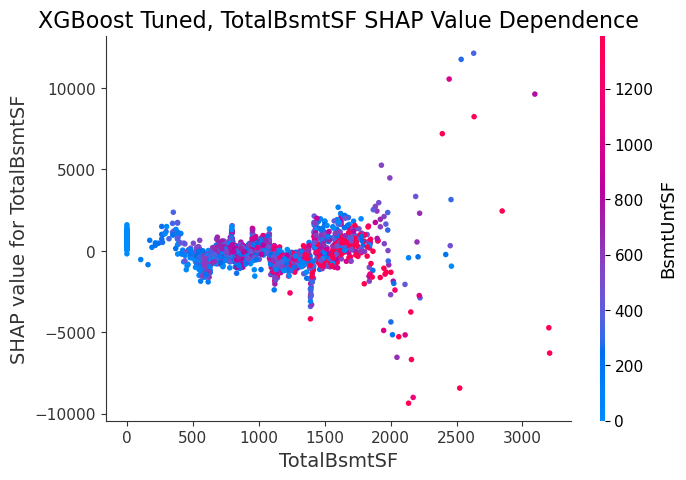

In [129]:
shap.dependence_plot("TotalBsmtSF", shap_values, X, interaction_index='BsmtUnfSF', show=False)


plt.title('XGBoost Tuned, TotalBsmtSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for TotalBsmtSF', fontsize=14)
plt.xlabel('TotalBsmtSF', fontsize=14);
plt.show()


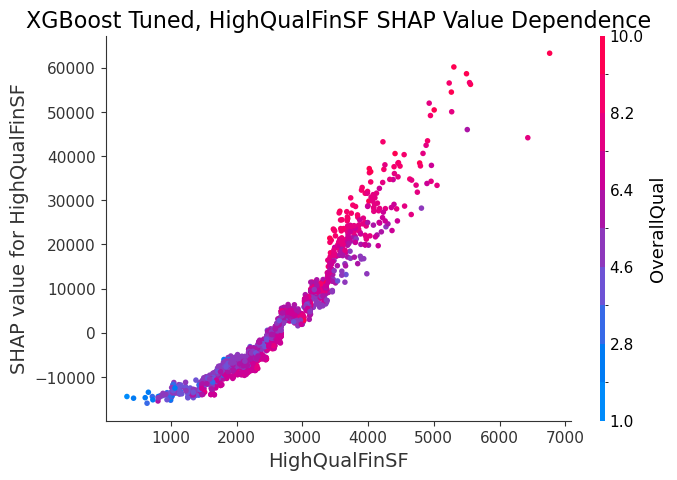

In [104]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("HighQualFinSF", shap_values, X, interaction_index="OverallQual", show=False)

plt.title('XGBoost Tuned, HighQualFinSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for HighQualFinSF', fontsize=14)
plt.xlabel('HighQualFinSF', fontsize=14);
plt.show()

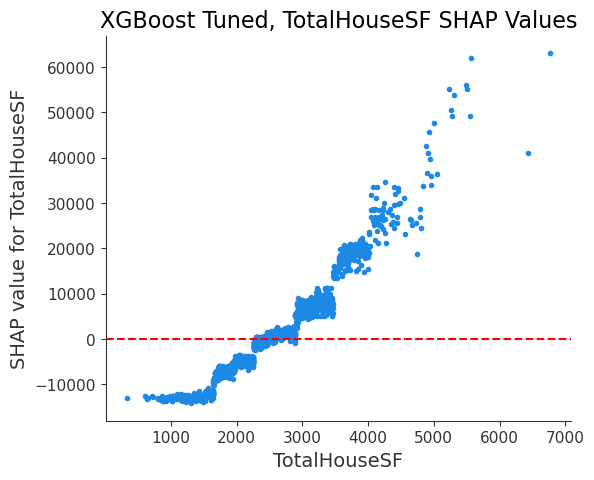

In [96]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, TotalHouseSF SHAP Values', fontsize=16)

plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

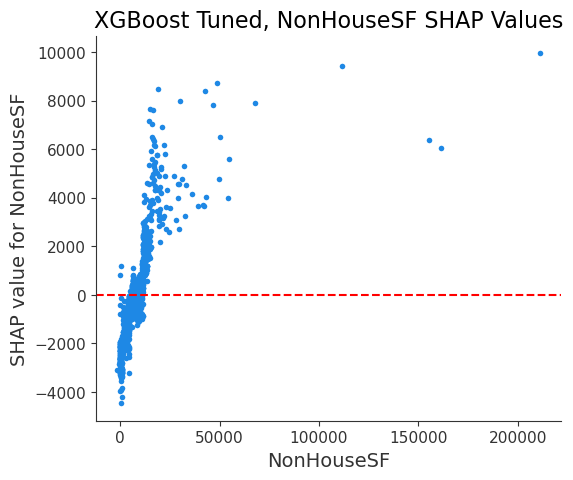

In [98]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("NonHouseSF", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, NonHouseSF SHAP Values', fontsize=16)

plt.ylabel('SHAP value for NonHouseSF', fontsize=14)
plt.xlabel('NonHouseSF', fontsize=14);

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

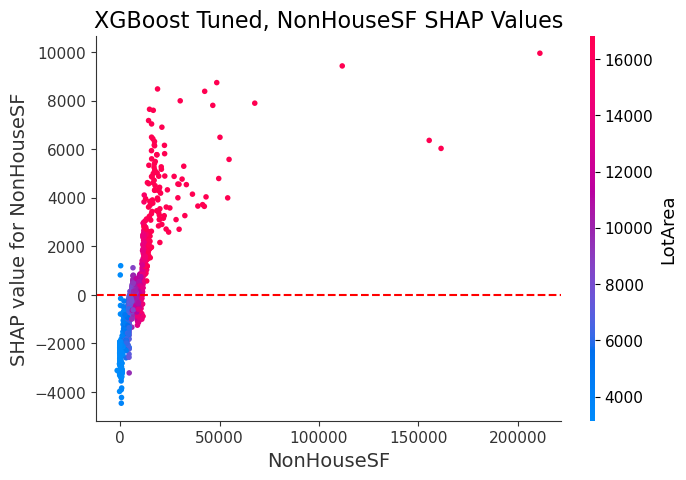

In [100]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("NonHouseSF", shap_values, X, interaction_index="LotArea", show=False)

plt.title('XGBoost Tuned, NonHouseSF SHAP Values', fontsize=16)

plt.ylabel('SHAP value for NonHouseSF', fontsize=14)
plt.xlabel('NonHouseSF', fontsize=14);

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

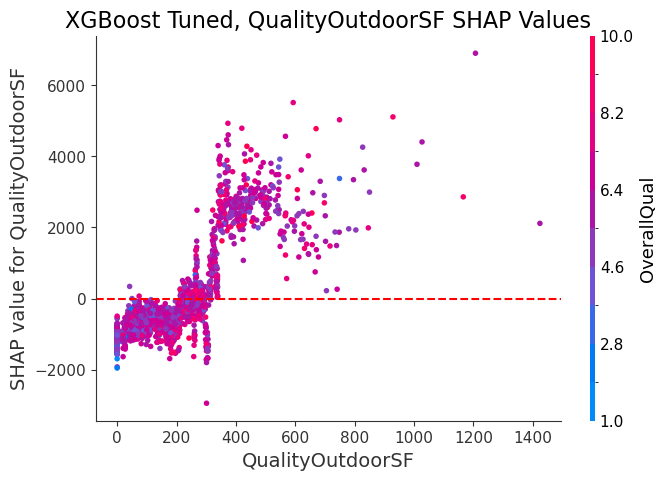

In [109]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("QualityOutdoorSF", shap_values, X, interaction_index='OverallQual', show=False)

plt.title('XGBoost Tuned, QualityOutdoorSF SHAP Values', fontsize=16)

plt.ylabel('SHAP value for QualityOutdoorSF', fontsize=14)
plt.xlabel('QualityOutdoorSF', fontsize=14);

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

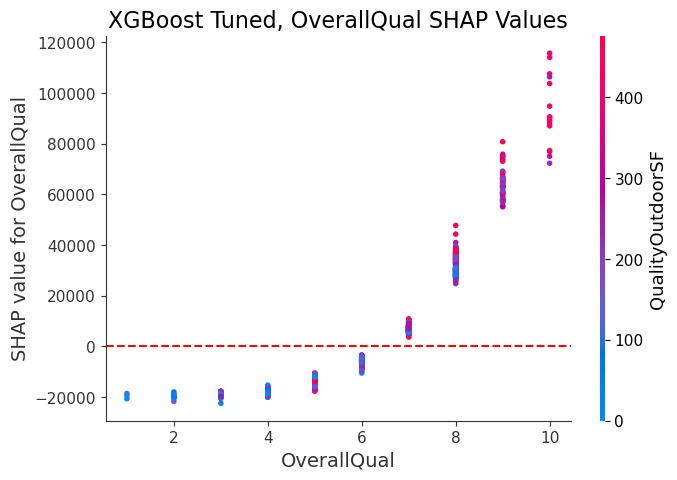

In [113]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("OverallQual", shap_values, X, interaction_index='QualityOutdoorSF', show=False)

plt.title('XGBoost Tuned, OverallQual SHAP Values', fontsize=16)

plt.ylabel('SHAP value for OverallQual', fontsize=14)
plt.xlabel('OverallQual', fontsize=14);

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

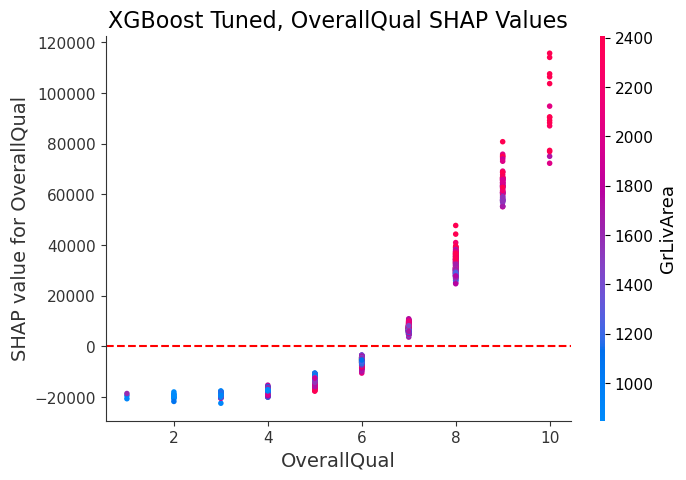

In [120]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("OverallQual", shap_values, X, interaction_index='GrLivArea', show=False)

plt.title('XGBoost Tuned, OverallQual SHAP Values', fontsize=16)

plt.ylabel('SHAP value for OverallQual', fontsize=14)
plt.xlabel('OverallQual', fontsize=14);

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

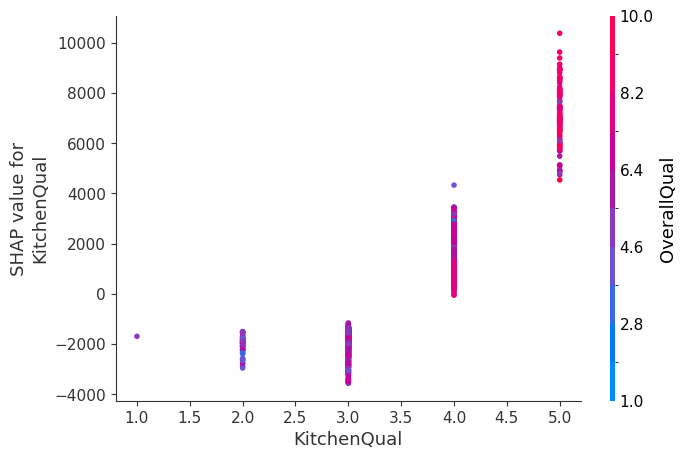

In [114]:
shap.dependence_plot("KitchenQual", shap_values, X, interaction_index='OverallQual', show=False)



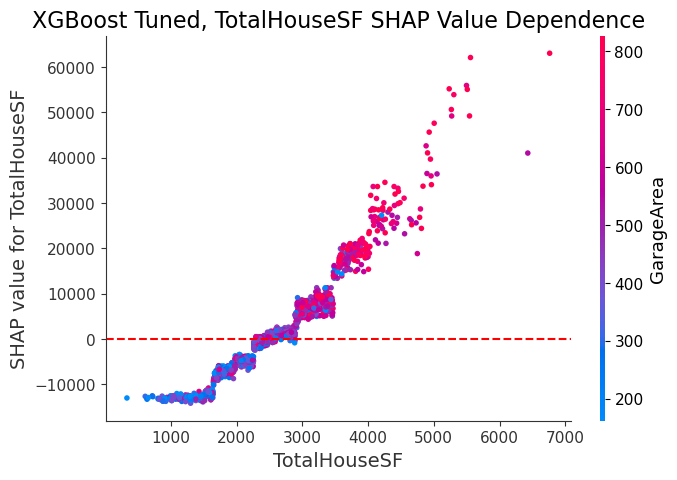

In [70]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index="GarageArea", show=False)

plt.title('XGBoost Tuned, TotalHouseSF SHAP Value Dependence', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')


plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);
plt.show()

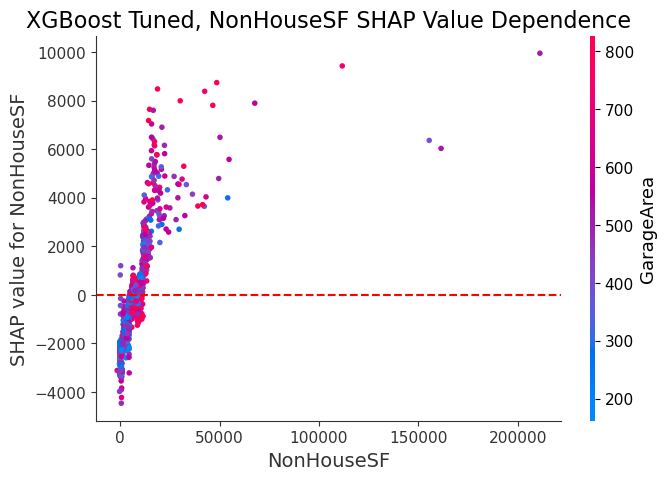

In [69]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("NonHouseSF", shap_values, X, interaction_index="GarageArea", show=False)

plt.title('XGBoost Tuned, NonHouseSF SHAP Value Dependence', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')


plt.ylabel('SHAP value for NonHouseSF', fontsize=14)
plt.xlabel('NonHouseSF', fontsize=14);
plt.show()

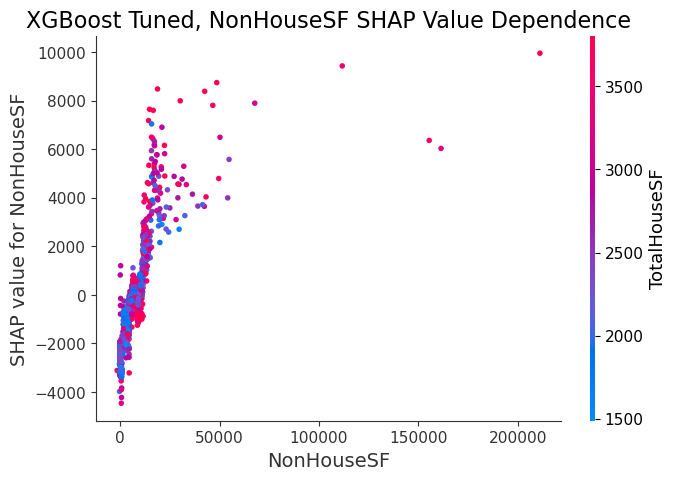

In [57]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("NonHouseSF", shap_values, X, interaction_index="TotalHouseSF", show=False)

plt.title('XGBoost Tuned, NonHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for NonHouseSF', fontsize=14)
plt.xlabel('NonHouseSF', fontsize=14);
plt.show()

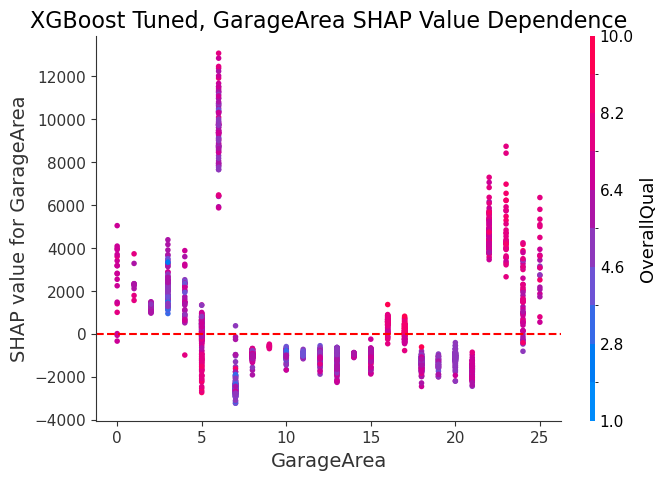

In [371]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("Neighborhood", shap_values, X, interaction_index='OverallQual', show=False)

plt.title('XGBoost Tuned, GarageArea SHAP Value Dependence', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('SHAP value for GarageArea', fontsize=14)
plt.xlabel('GarageArea', fontsize=14);
plt.show()

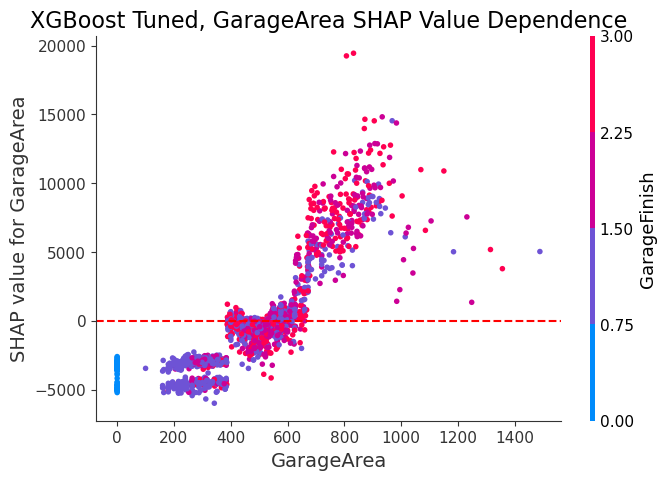

In [373]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("GarageArea", shap_values, X, interaction_index='GarageFinish', show=False)

plt.title('XGBoost Tuned, GarageArea SHAP Value Dependence', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('SHAP value for GarageArea', fontsize=14)
plt.xlabel('GarageArea', fontsize=14);
plt.show()

In [ ]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("GarageArea", shap_values, X, interaction_index='OverallQual', show=False)

plt.title('XGBoost Tuned, GarageArea SHAP Value Dependence', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('SHAP value for GarageArea', fontsize=14)
plt.xlabel('GarageArea', fontsize=14);
plt.show()

In [ ]:
plt.title('XGBoost Tuned, TotalHouseSF SHAP Values', fontsize=16)

plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

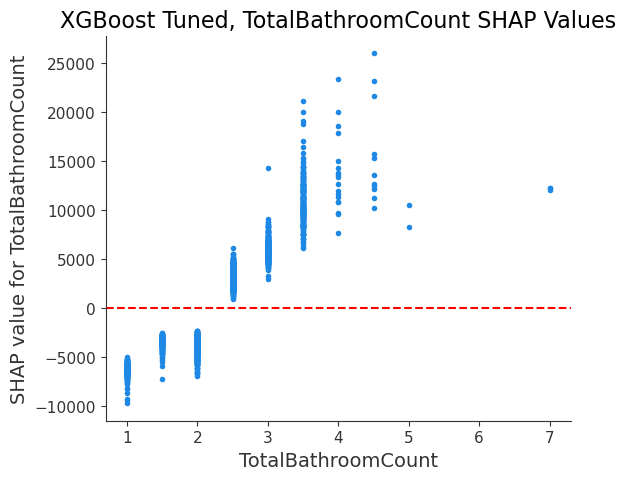

In [81]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalBathroomCount", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, TotalBathroomCount SHAP Values', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('SHAP value for TotalBathroomCount', fontsize=14)
plt.xlabel('TotalBathroomCount', fontsize=14);
plt.show()

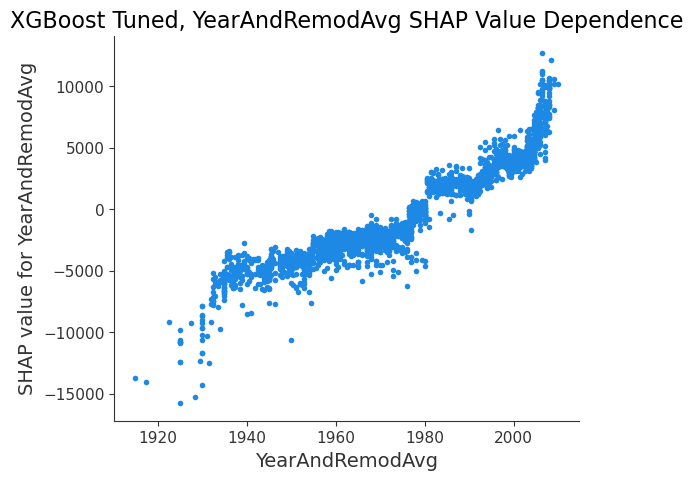

In [58]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("YearAndRemodAvg", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, YearAndRemodAvg SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for YearAndRemodAvg', fontsize=14)
plt.xlabel('YearAndRemodAvg', fontsize=14);
plt.show()

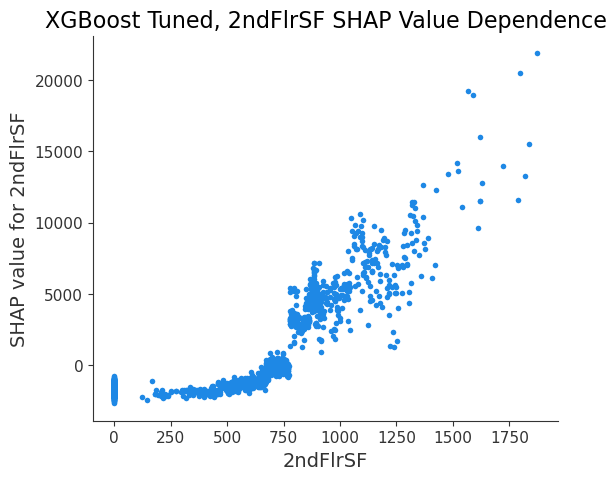

In [132]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("2ndFlrSF", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, 2ndFlrSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for 2ndFlrSF', fontsize=14)
plt.xlabel('2ndFlrSF', fontsize=14);
plt.show()

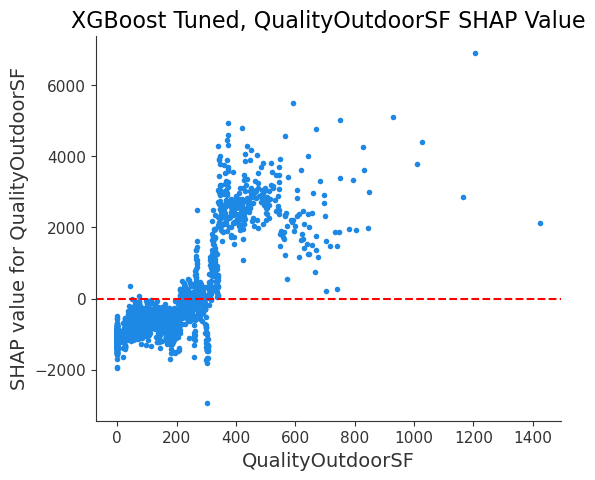

In [117]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("QualityOutdoorSF", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, QualityOutdoorSF SHAP Value', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('SHAP value for QualityOutdoorSF', fontsize=14)
plt.xlabel('QualityOutdoorSF', fontsize=14);
plt.show()

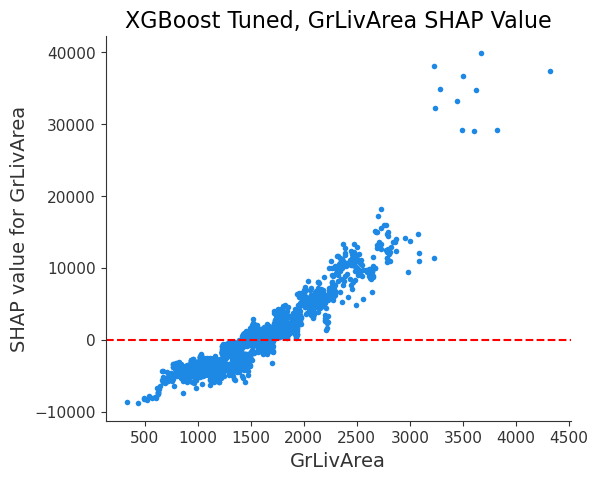

In [119]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("GrLivArea", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, GrLivArea SHAP Value', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('SHAP value for GrLivArea', fontsize=14)
plt.xlabel('GrLivArea', fontsize=14);
plt.show()

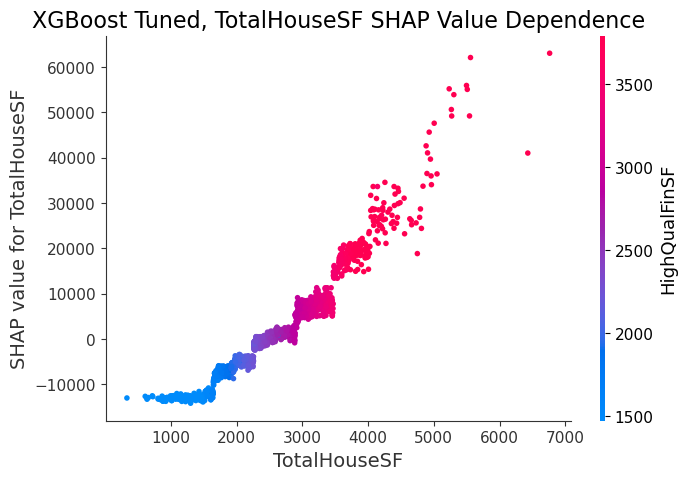

In [59]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index='HighQualFinSF', show=False)

plt.title('XGBoost Tuned, TotalHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);
plt.show()

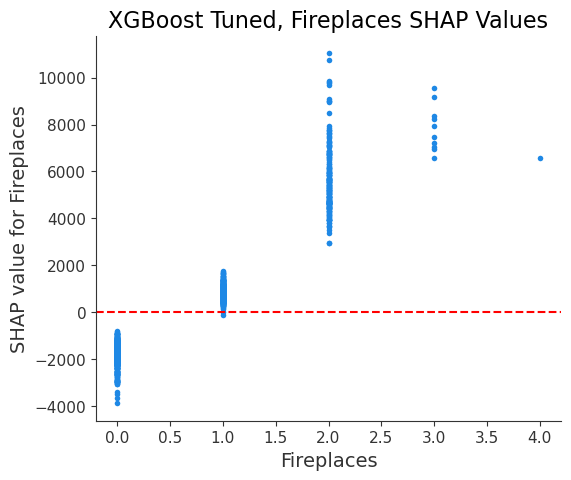

In [82]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("Fireplaces", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, Fireplaces SHAP Values', fontsize=16)
plt.axhline(y=0, color='r', linestyle='--')

plt.ylabel('SHAP value for Fireplaces', fontsize=14)
plt.xlabel('Fireplaces', fontsize=14);
plt.show()

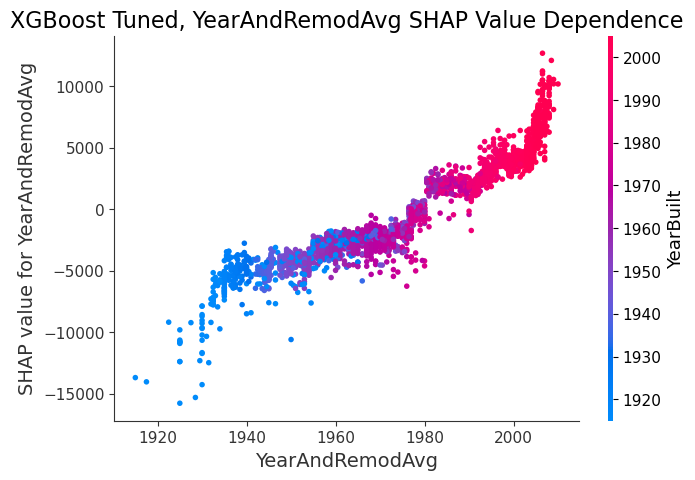

In [60]:
#YearBuilt LowQualFinSF

#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("YearAndRemodAvg", shap_values, X, interaction_index="YearBuilt", show=False)

plt.title('XGBoost Tuned, YearAndRemodAvg SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for YearAndRemodAvg', fontsize=14)
plt.xlabel('YearAndRemodAvg', fontsize=14);
plt.show()

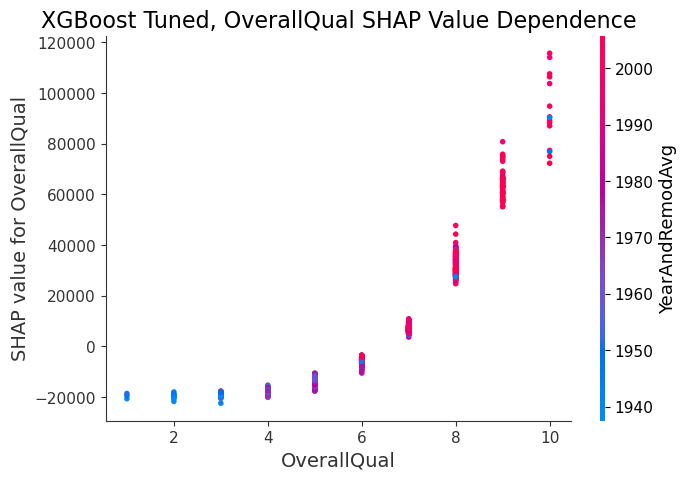

In [45]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("OverallQual", shap_values, X, interaction_index="YearAndRemodAvg", show=False)

plt.title('XGBoost Tuned, OverallQual SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for OverallQual', fontsize=14)
plt.xlabel('OverallQual', fontsize=14);
plt.show()

In [135]:
shap_df.OverallQual

0       -5330.956055
1      -11544.231445
2      -12297.954102
3      -17479.820312
4       27745.304688
            ...     
2405    -6120.948730
2406   -19818.037109
2407   -15124.112305
2408     6305.358398
2409    30093.132812
Name: OverallQual, Length: 2410, dtype: float32

In [169]:
shap_df.describe()

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.0,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.0,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000
mean,-239.926300,35.511879,4.558093,105.104813,-140.500443,3.150360,-5.089588,19.465309,-18.230669,0.0,-9.184189,1.895338,87.700478,14.468629,-1.576775,23.600920,-8.820882,231.089859,89.290291,19.292927,-90.740181,-8.574772,-0.107227,-8.537624,7.465737,9.939936,-159.345490,-107.804619,0.960973,-154.775269,-30.708565,2.402845,57.845551,-13.164850,-45.181850,-4.782662,12.474881,-0.201277,-49.035645,5.167366,-134.708313,59.105873,3.243175,4.150111,-85.166451,-1.101826,24.547504,-3.717377,111.867424,-8.809891,-34.698223,22.893124,-12.346127,-196.989899,24.592237,-23.043074,121.106369,-40.918175,-27.129383,-94.628181,82.203773,-300.219452,-0.388818,31.643919,5.897805,10.398613,-8.283050,-28.021927,-0.589716,34.748371,-5.266510,-1.118975,-8.204784,-2.040399,0.0,501.330383,56.987293,-124.429176,-30.223061,-3.877966,143.177689,44.148430,11.544096,176.378571
std,4772.973145,786.876404,1106.117798,1384.439331,3219.829590,231.041641,463.406433,495.698517,489.417236,0.0,633.334351,433.027069,2585.513916,2085.612305,290.361755,904.246582,532.485596,19234.044922,4419.122070,2606.695557,1225.345093,451.254089,495.090851,1191.872192,239.722763,122.374557,1992.943970,810.852539,256.520966,1022.146606,1150.409546,365.789032,2288.686035,661.166443,3226.057861,109.022812,658.023438,2017.592773,983.354431,99.014603,1189.900879,1340.985229,93.079742,3795.354248,3042.369141,185.635361,511.022400,68.837967,131.620514,82.730850,466.293060,602.327026,2495.281982,824.922546,2082.354980,2176.824463,2156.378174,616.671570,1484.225464,408.176331,748.996460,3564.093262,104.076805,581.914429,426.784210,711.899963,720.127869,799.570801,201.482880,1827.109253,88.878456,1038.387573,232.612076,176.518417,0.0,9639.212891,5746.074707,1257.451782,4248.306152,1452.088379,11108.236328,876.564941,946.363708,455.689148
min,-8839.781250,-2848.458252,-7035.485352,-6639.058105,-8117.947266,-4891.417480,-583.063049,-961.061707,-1929.983398,0.0,-5052.898438,-371.321106,-3234.186035,-13812.859375,-5038.883301,-3064.266113,-1194.626953,-22402.490234,-18689.19

In [154]:
# import pickle

# # Write the SHAP values to the file
# with open('shapval.pkl', 'wb') as dest:
#     pickle.dump(shap_values, dest, protocol=pickle.HIGHEST_PROTOCOL)

# # Load the pickled file
# with open('shapval.pkl', 'rb') as f:
#     pickled_shap_values = pickle.load(f)

In [167]:
shap_values[:,X["OverallQual"]].data

In [186]:
features_lst = ['GarageArea', '1stFlrSF', '2ndFlrSF', 'QualityOutdoorSF', 'Fireplaces', 'TotalHouseSF', 'TotalBathroomCount', 'BsmtFinSF1','BsmtUnfSF', 'GrLivArea', 'OverallQual']

['GarageArea',
 '1stFlrSF',
 '2ndFlrSF',
 'QualityOutdoorSF',
 'Fireplaces',
 'TotalHouseSF',
 'TotalBathroomCount',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'GrLivArea',
 'OverallQual']

In [193]:
shap_df['GrLivArea']

0      -5198.206543
1      -4982.917480
2      -4035.662354
3      -3799.285156
4         23.243870
           ...     
2405   -3758.349854
2406    1418.599121
2407    5777.237305
2408     849.988220
2409    1272.307739
Name: GrLivArea, Length: 2410, dtype: float32

In [201]:
filtered_GrLivArea_shap_df = shap_df[(shap_df['GrLivArea'] >= -100) & (shap_df['GrLivArea'] <= 100)]
filtered_GrLivArea_shap_df.GrLivArea.mean()

4.0755587

In [214]:
Xc

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,856,30,5,60.0,7890,1,1,3,3,0,0,0,19,2,2,0,2,6,6,1939,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,3,238.0,1,0.0,618.0,856.0,1,3,1,3,856,0,0,1.0,0.0,1,0,2,1,3,4,6,1,5,5,1939.0,1,2.0,399.0,4,4,2,0,0,0,0,166,1,3,2010,9,4,1712.0,2.0,166,1944.5,6178.0,1712.0,21.698352,0.760456,2.103929
1,1049,120,5,42.0,4235,1,1,3,3,0,4,0,7,2,2,4,2,5,5,1984,1984,1,0,6,6,1,149.0,4,3,1,5,4,3,3,552.0,2,393.0,104.0,1049.0,1,3,1,3,1049,0,0,1.0,0.0,2,0,2,1,4,5,6,0,1,1,1984.0,3,1.0,266.0,4,4,2,0,105,0,0,0,1,2,2009,9,4,2098.0,3.0,105,1984.0,2137.0,2098.0,49.539551,0.991736,2.479339
2,1001,30,1,60.0,6060,1,1,3,3,0,4,0,10,2,2,0,2,5,9,1930,2007,3,0,8,8,2,0.0,4,3,0,4,4,2,2,737.0,1,0.0,100.0,837.0,1,5,1,3,1001,0,0,0.0,0.0,1,0,2,1,4,5,6,0,1,5,1930.0,1,1.0,216.0,4,2,0,154,0,42,86,0,1,11,2007,9,4,1838.0,1.0,282,1968.5,4222.0,1838.0,30.330033,0.990099,4.653465
3,1039,70,5,80.0,8146,1,1,3,3,0,0,0,18,2,2,0,5,4,8,1900,2003,1,0,8,8,2,0.0,4,4,0,3,4,2,1,0.0,1,0.0,405.0,405.0,1,4,1,3,717,322,0,0.0,0.0,1,0,2,1,3,6,6,0,1,5,1940.0,1,1.0,281.0,4,4,0,0,0,168,0,111,1,5,2009,9,4,1444.0,1.0,279,1951.5,6702.0,1444.0,17.726492,0.982077,3.424994
4,1665,60,5,70.0,8400,1,1,3,3,0,4,0,15,2,2,0,5,8,6,2001,2001,1,0,12,13,2,0.0,4,3,2,5,4,2,3,643.0,1,0.0,167.0,810.0,1,5,1,3,810,855,0,1.0,0.0,2,1,3,1,4,6,6,0,1,1,2001.0,3,2.0,528.0,4,4,2,0,45,0,0,0,1,11,2009,9,4,2475.0,3.5,45,2001.0,5925.0,2475.0,29.464286,0.833333,0.535714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,952,30,5,51.5,8854,1,1,3,3,0,4,0,3,2,2,0,1,6,6,1916,1950,1,0,13,14,2,0.0,3,3,0,4,4,2,1,0.0,1,0.0,952.0,952.0,3,2,0,1,952,0,0,0.0,0.0,1,0,2,1,2,4,6,1,5,5,1916.0,1,1.0,192.0,3,2,1,0,98,0,0,40,1,5,2009,9,4,1904.0,1.0,138,1933.0,6950.0,1904.0,21.504405,0.581658,1.558618
2572,1733,20,5,65.0,13680,1,1,0,3,0,1,0,7,2,2,0,2,3,5,1955,1955,3,0,3,14,2,0.0,3,3,3,1,1,1,0,0.0,0,0.0,0.0,0.0,1,5,1,0,1733,0,0,0.0,0.0,2,0,4,1,3,8,3,1,5,1,1955.0,1,2.0,452.0,4,4,2,0,0,0,0,0,1,6,2009,9,4,1733.0,2.0,0,1955.0,11947.0,1733.0,12.668129,0.475146,0.000000
2573,2002,90,4,82.0,6270,1,1,3,1,0,4,0,6,2,2,2,5,5,6,1949,1950,1,0,8,8,2,0.0,3,3,1,4,4,2,1,284.0,1,0.0,717.0,1001.0,1,3,0,0,1001,1001,0,0.0,0.0,2,0,4,2,3,8,6,0,1,0,1949.0,1,3.0,871.0,4,4,2,0,0,0,0,0,1,8,2007,9,4,3003.0,2.0,0,1949.5,3267.0,3003.0,47.894737,1.307815,0.000000
2574,1842,60,5,70.0,8826,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2000,2000,1,0,12,13,1,144.0,4,3,2,5,4,2,3,841.0,1,0.0,144.0,985.0,1,5,1,3,985,857,0,1.0,0.0,2,1,3,1,4,7,6,1,4,1,2000.0,3,2.0,486.0,4,4,2,193,96,0,0,0,1,7,2007,9,4,2827.0,3.5,289,2000.0,5999.0,2827.0,32.030365,0.793111,3.274416


In [212]:
Xc = X.copy()
X_reset = Xc.reset_index(drop=True)
shap_df_reset = shap_df.reset_index(drop=True)

shap_df_renamed = shap_df_reset.add_suffix('_shap')

# Concatenate original_df and shap_df along the columns axis
shap_associated_df = pd.concat([X_reset, shap_df_renamed], axis=1)


In [213]:
shap_associated_df

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio,GrLivArea_shap,MSSubClass_shap,MSZoning_shap,LotFrontage_shap,LotArea_shap,Street_shap,Alley_shap,LotShape_shap,LandContour_shap,Utilities_shap,LotConfig_shap,LandSlope_shap,Neighborhood_shap,Condition1_shap,Condition2_shap,BldgType_shap,HouseStyle_shap,OverallQual_shap,OverallCond_shap,YearBuilt_shap,YearRemodAdd_shap,RoofStyle_shap,RoofMatl_shap,Exterior1st_shap,Exterior2nd_shap,MasVnrType_shap,MasVnrArea_shap,ExterQual_shap,ExterCond_shap,Foundation_shap,BsmtQual_shap,BsmtCond_shap,BsmtExposure_shap,BsmtFinType1_shap,BsmtFinSF1_shap,BsmtFinType2_shap,BsmtFinSF2_shap,BsmtUnfSF_shap,TotalBsmtSF_shap,Heating_shap,HeatingQC_shap,CentralAir_shap,Electrical_shap,1stFlrSF_shap,2ndFlrSF_shap,LowQualFinSF_shap,BsmtFullBath_shap,BsmtHalfBath_shap,FullBath_shap,HalfBath_shap,BedroomAbvGr_shap,KitchenAbvGr_shap,KitchenQual_shap,TotRmsAbvGrd_shap,Functional_shap,Fireplaces_shap,FireplaceQu_shap,GarageType_shap,GarageYrBlt_shap,GarageFinish_shap,GarageCars_shap,GarageArea_shap,GarageQual_shap,GarageCond_shap,PavedDrive_shap,WoodDeckSF_shap,OpenPorchSF_shap,EnclosedPorch_shap,3SsnPorch_shap,ScreenPorch_shap,Fence_shap,MoSold_shap,YrSold_shap,SaleType_shap,SaleCondition_shap,TotalHouseSF_shap,TotalBathroomCount_shap,QualityOutdoorSF_shap,YearAndRemodAvg_shap,NonHouseSF_shap,HighQualFinSF_shap,HouseLotRatio_shap,FrontageLotRatio_shap,QualityOutdoorLotRatio_shap
0,856,30,5,60.0,7890,1,1,3,3,0,0,0,19,2,2,0,2,6,6,1939,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,3,238.0,1,0.0,618.0,856.0,1,3,1,3,856,0,0,1.0,0.0,1,0,2,1,3,4,6,1,5,5,1939.0,1,2.0,399.0,4,4,2,0,0,0,0,166,1,3,2010,9,4,1712.0,2.0,166,1944.5,6178.0,1712.0,21.698352,0.760456,2.103929,-5198.206543,-894.863647,279.376373,-1113.995483,-1919.580811,17.795887,-69.741554,-347.475067,-89.535927,0.0,96.799927,-43.872505,-1067.572510,574.218384,19.682699,339.307098,-424.916901,-5330.956055,823.307922,-2432.204834,-1213.246460,90.360237,-31.787872,-370.928619,131.721390,-39.199947,-372.875031,-263.404480,9.790520,-288.934143,-677.427979,-39.990795,-614.502930,459.253235,-1577.037231,6.653982,25.590317,-854.425903,-90.622009,-1.495161,-1237.836304,393.913574,2.699471,-2165.985840,-2429.384277,-21.325642,243.918259,-14.567040,133.511902,-0.883741,121.341202,114.767776,-1767.793335,-118.052864,451.275116,1098.392334,2388.713867,-664.930847,-118.879044,-366.203674,714.589661,390.024384,-15.464041,256.765472,211.744080,-242.191284,-358.884552,-50.944424,-26.883188,5711.214844,-3.171095,-1174.991455,371.400513,11.693683,0.0,-8371.689453,-3870.207520,-636.886230,-5102.260254,133.101303,-9226.297852,-180.693771,86.110718,242.953110
1,1049,120,5,42.0,4235,1,1,3,3,0,4,0,7,2,2,4,2,5,5,1984,1984,1,0,6,6,1,149.0,4,3,1,5,4,3,3,552.0,2,393.0,104.0,1049.0,1,3,1,3,1049,0,0,1.0,0.0,2,0,2,1,4,5,6,0,1,1,1984.0,3,1.0,266.0,4,4,2,0,105,0,0,0,1,2,2009,9,4,2098.0,3.0,105,1984.0,2137.0,2098.0,49.539551,0.991736,2.479339,-4982.917480,369.071716,284.568604,-698.334656,-3302.337158,15.341434,-39.518665,-472.761444,-65.691177,0.0,187.703140,-47.868946,-2532.185547,628.972595,21.820160,-1833.333984,-358

In [224]:
filtered_GrLivArea_shap_df = shap_associated_df[(shap_associated_df['GrLivArea_shap'] >= -100) & (shap_associated_df['GrLivArea_shap'] <= 100)]
mean = filtered_GrLivArea_shap_df.GrLivArea.mean()
filtered_GrLivArea_shap_df.GrLivArea.mean()

1567.2162162162163

In [235]:
above_threshold_df = shap_associated_df[shap_associated_df['GrLivArea'] > mean]
above_threshold_df

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio,GrLivArea_shap,MSSubClass_shap,MSZoning_shap,LotFrontage_shap,LotArea_shap,Street_shap,Alley_shap,LotShape_shap,LandContour_shap,Utilities_shap,LotConfig_shap,LandSlope_shap,Neighborhood_shap,Condition1_shap,Condition2_shap,BldgType_shap,HouseStyle_shap,OverallQual_shap,OverallCond_shap,YearBuilt_shap,YearRemodAdd_shap,RoofStyle_shap,RoofMatl_shap,Exterior1st_shap,Exterior2nd_shap,MasVnrType_shap,MasVnrArea_shap,ExterQual_shap,ExterCond_shap,Foundation_shap,BsmtQual_shap,BsmtCond_shap,BsmtExposure_shap,BsmtFinType1_shap,BsmtFinSF1_shap,BsmtFinType2_shap,BsmtFinSF2_shap,BsmtUnfSF_shap,TotalBsmtSF_shap,Heating_shap,HeatingQC_shap,CentralAir_shap,Electrical_shap,1stFlrSF_shap,2ndFlrSF_shap,LowQualFinSF_shap,BsmtFullBath_shap,BsmtHalfBath_shap,FullBath_shap,HalfBath_shap,BedroomAbvGr_shap,KitchenAbvGr_shap,KitchenQual_shap,TotRmsAbvGrd_shap,Functional_shap,Fireplaces_shap,FireplaceQu_shap,GarageType_shap,GarageYrBlt_shap,GarageFinish_shap,GarageCars_shap,GarageArea_shap,GarageQual_shap,GarageCond_shap,PavedDrive_shap,WoodDeckSF_shap,OpenPorchSF_shap,EnclosedPorch_shap,3SsnPorch_shap,ScreenPorch_shap,Fence_shap,MoSold_shap,YrSold_shap,SaleType_shap,SaleCondition_shap,TotalHouseSF_shap,TotalBathroomCount_shap,QualityOutdoorSF_shap,YearAndRemodAvg_shap,NonHouseSF_shap,HighQualFinSF_shap,HouseLotRatio_shap,FrontageLotRatio_shap,QualityOutdoorLotRatio_shap
4,1665,60,5,70.0,8400,1,1,3,3,0,4,0,15,2,2,0,5,8,6,2001,2001,1,0,12,13,2,0.0,4,3,2,5,4,2,3,643.0,1,0.0,167.0,810.0,1,5,1,3,810,855,0,1.0,0.0,2,1,3,1,4,6,6,0,1,1,2001.0,3,2.0,528.0,4,4,2,0,45,0,0,0,1,11,2009,9,4,2475.0,3.5,45,2001.0,5925.0,2475.0,29.464286,0.833333,0.535714,23.243870,908.479065,328.045502,-32.443359,-1036.211304,17.388145,-50.164810,-282.679993,-84.264297,0.0,10.528648,-96.781853,-865.339417,720.336304,19.051186,290.828064,416.775085,27745.304688,1347.792603,2645.739258,429.310944,162.092102,-34.682518,-216.003464,14.915606,-44.679646,-727.252930,638.356689,20.722897,364.113342,254.486679,-25.982239,-976.443420,660.004944,948.211792,-5.126337,90.686172,1600.197144,-244.807098,-2.399972,642.124634,496.183319,30.930481,-2627.479004,3277.868652,-16.054552,436.133575,-8.064825,26.833569,-16.126608,45.201267,77.057068,338.236389,-953.945984,529.199646,-1928.414307,-1778.538086,513.872986,935.645630,507.818115,445.609680,-2310.240723,-9.451023,144.435776,39.888012,-208.452896,674.906311,-69.935898,-16.572641,-416.122925,10.394322,-2308.446533,-232.487091,5.681112,0.0,658.629456,9598.282227,-691.306763,4152.930176,-341.406525,-2932.830566,159.760773,174.344116,566.556396
5,1922,85,5,64.0,7301,1,1,3,3,0,0,0,7,2,2,0,6,7,5,2003,2003,1,0,6,6,1,500.0,4,3,3,1,1,1,0,0.0,0,0.0,0.0,0.0,1,5,1,3,495,1427,0,0.0,0.0,3,0,4,1,4,7,6,1,6,3,2003.0,2,2.0,672.0,4,4,2,0,0,177,0,0,1,7,2009,3,4,1922.0,3.0,177,2003.0,5379.0,1922.0,26.325161,0.876592,2.424325,754.651001,875.073181,438.200714,-705.176270,-3522.909180,17.388145,-42.813328,-347.243591,-59.974861,0.0,-57.148746,-154.561798,-2383.364746,632.076172,16.129660,277.229614,1152.875854,6082.476074,-2354.175293,

In [267]:
filtered_GrLivArea_shap_df = shap_associated_df[(shap_associated_df['GrLivArea_shap'] >= -100) & (shap_associated_df['GrLivArea_shap'] <= 100)]
mean = filtered_GrLivArea_shap_df.GrLivArea.mean()
print('X Mean: ', filtered_GrLivArea_shap_df.GrLivArea.mean())

X Mean:  1567.2162162162163


In [270]:
filtered_GrLivArea_shap_df = shap_associated_df[(shap_associated_df['GrLivArea_shap'] >= -100) & (shap_associated_df['GrLivArea_shap'] <= 100)]
mean = filtered_GrLivArea_shap_df.GrLivArea.mean()
print('X Mean: ', filtered_GrLivArea_shap_df.GrLivArea.mean())

# Assuming above_threshold_df contains your data
Xs = shap_associated_df[['GrLivArea']]  # Independent variable
ys = shap_associated_df['GrLivArea_shap']  # Dependent variable

# Initialize and fit the linear regression model
smodel = LinearRegression()
smodel.fit(Xs, ys)

# Predict on the test set
y_pred = smodel.predict(Xs)

# Evaluate the model
mse = mean_squared_error(ys, y_pred)
print("Mean Squared Error:", mse)

# Get the coefficient (slope) and intercept of the linear regression line
slope = smodel.coef_  # Coefficient (slope)intercept = smodel.intercept_
intercept = smodel.intercept_  # Intercept
print("Slope (Coefficient):", slope)
print("Intercept:", intercept)

X Mean:  1567.2162162162163
Mean Squared Error: 3555421.768060406
Slope (Coefficient): [9.07143822]
Intercept: -13643.348901897549


In [271]:
filtered_TotalHouseSF_shap_df = shap_associated_df[(shap_associated_df['TotalHouseSF_shap'] >= -100) & (shap_associated_df['TotalHouseSF_shap'] <= 100)]
mean = filtered_TotalHouseSF_shap_df.TotalHouseSF.mean()
print('X Mean: ', filtered_TotalHouseSF_shap_df.TotalHouseSF.mean())

# Assuming above_threshold_df contains your data
Xs = shap_associated_df[['TotalHouseSF']]  # Independent variable
ys = shap_associated_df['TotalHouseSF_shap']  # Dependent variable

# Initialize and fit the linear regression model
smodel = LinearRegression()
smodel.fit(Xs, ys)

# Predict on the test set
y_pred = smodel.predict(Xs)

# Evaluate the model
mse = mean_squared_error(ys, y_pred)
print("Mean Squared Error:", mse)

# Get the coefficient (slope) and intercept of the linear regression line
slope = smodel.coef_  # Coefficient (slope)intercept = smodel.intercept_
intercept = smodel.intercept_  # Intercept
print("Slope (Coefficient):", slope)
print("Intercept:", intercept)

X Mean:  2454.769230769231
Mean Squared Error: 6456442.055210916
Slope (Coefficient): [12.49901492]
Intercept: -30701.72910777439


In [280]:
shap_associated_df[(shap_associated_df['OverallQual'] == 7)].OverallQual_shap.mean()

7029.2026

In [316]:
oneBath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 1)].TotalBathroomCount_shap.mean()
one5Bath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 1.5)].TotalBathroomCount_shap.mean()
twoBath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 2)].TotalBathroomCount_shap.mean()
two5Bath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 2.5)].TotalBathroomCount_shap.mean()
threeBath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 3)].TotalBathroomCount_shap.mean()
three5Bath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 3.5)].TotalBathroomCount_shap.mean()
fourBath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 4)].TotalBathroomCount_shap.mean()
four5Bath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 4.5)].TotalBathroomCount_shap.mean()
fiveBath = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 5)].TotalBathroomCount_shap.mean()


In [338]:
(two5Bath + threeBath + three5Bath + fourBath + four5Bath)/5 - (oneBath + one5Bath + twoBath)/3

14361.4447265625

In [326]:
twoBath-oneBath

2677.0264

In [339]:
print(two5Bath - twoBath)
print(threeBath - twoBath)
print(three5Bath - twoBath)
print(fourBath - twoBath)



6652.8535
9624.649
14504.026
17314.254


In [341]:
(two5Bath + threeBath + three5Bath + fourBath + four5Bath) - twoBath

13515.6634765625

In [317]:
oneBath

-6313.5586

In [318]:
one5Bath - oneBath

2816.709

In [319]:
twoBath - one5Bath

-139.68262

In [320]:
two5Bath - twoBath

6652.8535

In [321]:
threeBath - two5Bath

2971.796

In [322]:
three5Bath - threeBath

4879.377

In [323]:
fourBath - three5Bath

2810.2275

In [324]:
four5Bath - fourBath

2168.2793

In [325]:
fiveBath - four5Bath

-6447.422

In [327]:
noFire = shap_associated_df[(shap_associated_df['Fireplaces'] == 0)].Fireplaces_shap.mean()
oneFire = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 1)].Fireplaces_shap.mean()
twoFire = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 2)].Fireplaces_shap.mean()
threeFire = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 3)].Fireplaces_shap.mean()
fourFire = shap_associated_df[(shap_associated_df['TotalBathroomCount'] == 4)].Fireplaces_shap.mean()

In [329]:
oneFire - noFire

851.66064

In [333]:
twoFire - oneFire

615.73987

In [334]:
threeFire - twoFire

803.3176

In [336]:
twoFire - noFire

1467.4005

In [335]:
fourFire - threeFire

1646.7346